# Polyhedral Compiler Hands-on with Caten


This tutorial demonstrates how to use `caten.polyhedral` to construct and transform schedules for high-performance kernels, including Matrix Multiplication optimization and Conv-Pool Fusion.


## 1. Setup


In [1]:
import sys
sys.path.append("../")

import caten.isl as I
import caten.polyhedral as P

print("Caten initialized.")

Caten initialized.


## 2. Gemm Optimization

Repro of this article
https://salykova.github.io/matmul-cpu

ScheduleNodeDomain(
    ┏ [domain] (M, N, K) (You are here)
    ┗  WMMA[i, j, k] : 0 ≤ i < M ∧ 0 ≤ j < N ∧ 0 ≤ k < K
      ┏ [band]
      ┃  WMMA[i, j, k] → i
      ┃  WMMA[i, j, k] → j
      ┗  WMMA[i, j, k] → k
        ┗ [leaf]
)
for (int c0 = 0; c0 < M; c0 += 1)
  for (int c1 = 0; c1 < N; c1 += 1)
    for (int c2 = 0; c2 < K; c2 += 1)
      assign(C[c1][c0], C[c1][c0] + A[c2][c0] * B[c1][c2]);



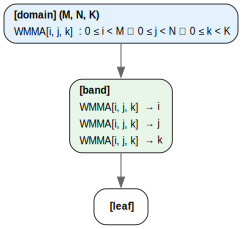

In [2]:
def create_gemm_schedule():
    A, B, C = map(I.expr, ("A", "B", "C"))
    zero = I.expr(0)

    with P.parameter("M, N, K"):
        with P.domain("{ WMMA[i,j,k] : 0<=i<M and 0<=j<N and 0<=k<K }") as gemm:
            with P.band("{ WMMA[i,j,k] -> [i, j, k] }"):
                P.stmt("C[j,i] = C[j,i], A[k,i], B[j,k]")[
                    lambda i, j, k: C[j, i].assign(C[j, i] + A[k, i] * B[j, k])
                ]
    return gemm

print(create_gemm_schedule())
print(create_gemm_schedule().to_c())
create_gemm_schedule().viz()

## 3. Conv2D+Pool2D On-the-fly reduction

Conv2D

Pool2D

In [7]:
S_POOL = 4
H_OUT = 128
W_OUT = 128
H_POOL = (H_OUT - S_POOL) // S_POOL + 1
W_POOL = (W_OUT - S_POOL) // S_POOL + 1

def conv2d():
    out, inp, wei = map(I.expr, ("Out", "In", "W"))
    zero = I.expr(0)

    with P.parameter("N, K_out, Cin, KH, KW"):
        d1 = P.domain(
            f"{{ S_conv_init[n,k,h,w] : "
            f"0<=n<N and 0<=k<K_out and 0<=h<{H_OUT} and 0<=w<{W_OUT} }}"
        )
        d2 = P.domain(
            f"{{ S_conv[n,k,h,w,c,kh,kw] : "
            f"0<=n<N and 0<=k<K_out and 0<=h<{H_OUT} and 0<=w<{W_OUT} and "
            f"0<=c<Cin and 0<=kh<KH and 0<=kw<KW }}"
        )

        with (d1 | d2) as conv:
            with P.filter("{ S_conv_init[n,k,h,w] }"):
                with P.band("{ S_conv_init[n,k,h,w] -> [n, k, h, w] }"):
                    P.stmt("Out[n,k,h,w] = 0")[
                        lambda n, k, h, w: out[n, k, h, w].assign(zero)
                    ]

            with P.filter("{ S_conv[n,k,h,w,c,kh,kw] }"):
                with P.band("{ S_conv[n,k,h,w,c,kh,kw] -> [n, k, h, w, c, kh, kw] }"):
                    P.stmt("Out[n,k,h,w] = Out[n,k,h,w], In[n,c,h+kh,w+kw], W[k,c,kh,kw]")[
                        lambda n, k, h, w, c, kh, kw:
                            out[n, k, h, w].assign(
                                out[n, k, h, w] + inp[n, c, h + kh, w + kw] * wei[k, c, kh, kw]
                            )
                    ]

    return conv

def pool2d():
    S_pool = I.expr(S_POOL)
    pool_buf, out = map(I.expr, ("PoolBuf", "Out"))
    neg_inf = I.expr("NEG_INF")

    with P.parameter("N, K_out"):
        d1 = P.domain(
            f"{{ S_pool_init[n,k,h,w] : "
            f"0<=n<N and 0<=k<K_out and 0<=h<{H_POOL} and 0<=w<{W_POOL} }}"
        )
        d2 = P.domain(
            f"{{ S_pool[n,k,h,w,rh,rw] : "
            f"0<=n<N and 0<=k<K_out and 0<=h<{H_POOL} and 0<=w<{W_POOL} and "
            f"0<=rh<{S_POOL} and 0<=rw<{S_POOL} }}"
        )

        with (d1 | d2) as pool:
            with P.filter("{ S_pool_init[n,k,h,w] }"):
                with P.band("{ S_pool_init[n,k,h,w] -> [n, k, h, w] }"):
                    P.stmt("PoolBuf[n,k,h,w] = -INF")[
                        lambda n, k, h, w: pool_buf[n, k, h, w].assign(neg_inf)
                    ]

            with P.filter("{ S_pool[n,k,h,w,rh,rw] }"):
                with P.band("{ S_pool[n,k,h,w,rh,rw] -> [n, k, h, w, rh, rw] }"):
                    P.stmt(f"PoolBuf[n,k,h,w] = PoolBuf[n,k,h,w], Out[n,k,h*{S_POOL}+rh,w*{S_POOL}+rw]")[
                        lambda n, k, h, w, rh, rw:
                            pool_buf[n, k, h, w].assign(
                                pool_buf[n, k, h, w].max(
                                    out[n, k, h * S_pool + rh, w * S_pool + rw]
                                )
                            )
                    ]
    return pool

ScheduleNodeDomain(
    ┏ [domain] (N, K_out, Cin, KH, KW) (You are here)
    ┃  S_conv[n, k, h, w, c, kh, kw] : 0 ≤ n < N ∧ 0 ≤ k < K_out ∧ 0 ≤ h ≤ 127 ∧ 0 ≤ w ≤ 127 ∧ 0 ≤ c < Cin ∧ 0 ≤ kh < KH ∧ 0 ≤ kw < KW
    ┗  S_conv_init[n, k, h, w]       : 0 ≤ n < N ∧ 0 ≤ k < K_out ∧ 0 ≤ h ≤ 127 ∧ 0 ≤ w ≤ 127
      ┗ [sequence]
        ┏ [filter]
        ┗  S_conv_init[n, k, h, w]
          ┏ [band]
          ┃  S_conv_init[n, k, h, w] → n
          ┃  S_conv_init[n, k, h, w] → k
          ┃  S_conv_init[n, k, h, w] → h
          ┗  S_conv_init[n, k, h, w] → w
            ┗ [leaf]
        ┏ [filter]
        ┗  S_conv[n, k, h, w, c, kh, kw]
          ┏ [band]
          ┃  S_conv[n, k, h, w, c, kh, kw] → n
          ┃  S_conv[n, k, h, w, c, kh, kw] → k
          ┃  S_conv[n, k, h, w, c, kh, kw] → h
          ┃  S_conv[n, k, h, w, c, kh, kw] → w
          ┃  S_conv[n, k, h, w, c, kh, kw] → c
          ┃  S_conv[n, k, h, w, c, kh, kw] → kh
          ┗  S_conv[n, k, h, w, c, kh, kw] → kw
           

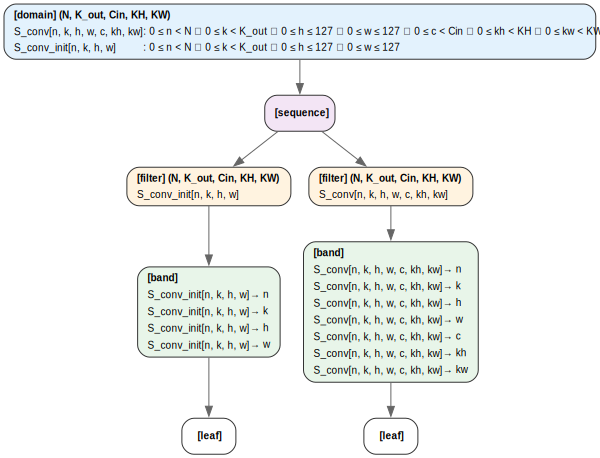

In [8]:
print(conv2d())
conv2d().viz()

ScheduleNodeDomain(
    ┏ [domain] (N, K_out) (You are here)
    ┃  S_pool_init[n, k, h, w]    : 0 ≤ n < N ∧ 0 ≤ k < K_out ∧ 0 ≤ h ≤ 31 ∧ 0 ≤ w ≤ 31
    ┗  S_pool[n, k, h, w, rh, rw] : 0 ≤ n < N ∧ 0 ≤ k < K_out ∧ 0 ≤ h ≤ 31 ∧ 0 ≤ w ≤ 31 ∧ 0 ≤ rh ≤ 3 ∧ 0 ≤ rw ≤ 3
      ┗ [sequence]
        ┏ [filter]
        ┗  S_pool_init[n, k, h, w]
          ┏ [band]
          ┃  S_pool_init[n, k, h, w] → n
          ┃  S_pool_init[n, k, h, w] → k
          ┃  S_pool_init[n, k, h, w] → h
          ┗  S_pool_init[n, k, h, w] → w
            ┗ [leaf]
        ┏ [filter]
        ┗  S_pool[n, k, h, w, rh, rw]
          ┏ [band]
          ┃  S_pool[n, k, h, w, rh, rw] → n
          ┃  S_pool[n, k, h, w, rh, rw] → k
          ┃  S_pool[n, k, h, w, rh, rw] → h
          ┃  S_pool[n, k, h, w, rh, rw] → w
          ┃  S_pool[n, k, h, w, rh, rw] → rh
          ┗  S_pool[n, k, h, w, rh, rw] → rw
            ┗ [leaf]
)


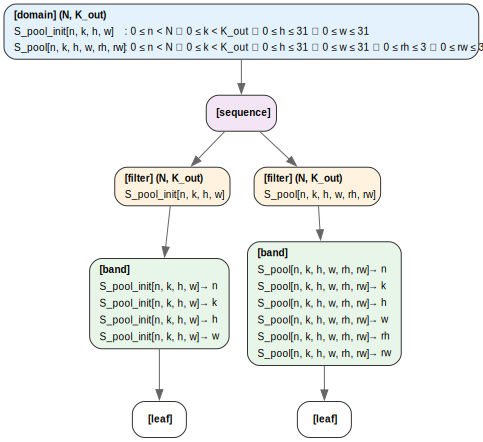

In [9]:
print(pool2d())
pool2d().viz()

{
  for (int c0 = 0; c0 < N; c0 += 1)
    for (int c1 = 0; c1 < K_out; c1 += 1)
      for (int c2 = 0; c2 <= 127; c2 += 1)
        for (int c3 = 0; c3 <= 127; c3 += 1)
          assign(Out[c0][c1][c2][c3], 0);
  for (int c0 = 0; c0 < N; c0 += 1)
    for (int c1 = 0; c1 < K_out; c1 += 1)
      for (int c2 = 0; c2 <= 127; c2 += 1)
        for (int c3 = 0; c3 <= 127; c3 += 1)
          for (int c4 = 0; c4 < Cin; c4 += 1)
            for (int c5 = 0; c5 < KH; c5 += 1)
              for (int c6 = 0; c6 < KW; c6 += 1)
                assign(Out[c0][c1][c2][c3], Out[c0][c1][c2][c3] + In[c0][c4][c2 + c5][c3 + c6] * W[c1][c4][c5][c6]);
  for (int c0 = 0; c0 < N; c0 += 1)
    for (int c1 = 0; c1 < K_out; c1 += 1)
      for (int c2 = 0; c2 <= 31; c2 += 1)
        for (int c3 = 0; c3 <= 31; c3 += 1)
          assign(PoolBuf[c0][c1][c2][c3], NEG_INF);
  for (int c0 = 0; c0 < N; c0 += 1)
    for (int c1 = 0; c1 < K_out; c1 += 1)
      for (int c2 = 0; c2 <= 31; c2 += 1)
        for (int c3 = 0; c3 <

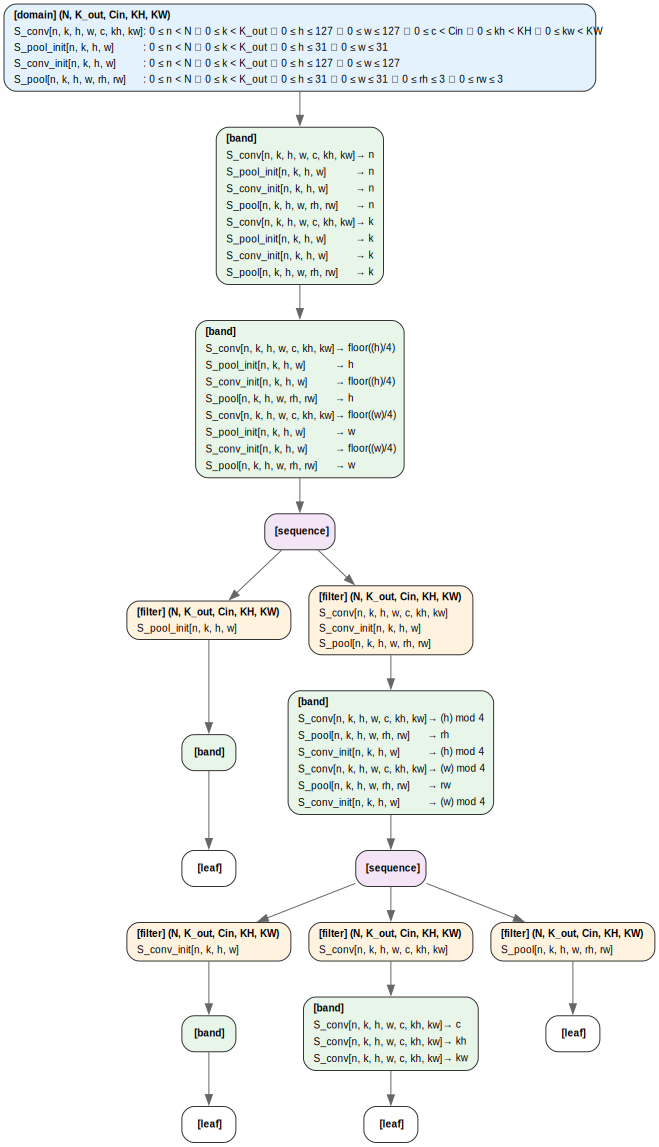

In [16]:
with (conv2d().finalize()+pool2d().finalize()).editor() as kernel:
    # Kernel Fusion
    with kernel.domain()[0] as dom:
        print(dom.to_c())
        with dom.sequence() as nk:
            nk[0].filter()[0].band().split(2)
            nk[1].filter()[0].band().split(2)
            nk[2].filter()[0].band().split(2)
            nk[3].filter()[0].band().split(2)
            nk.fuse()
        dom.band()[0].sequence().reorder(2, 0, 1, 3)
        with dom.band()[0].sequence() as hw:
            hw[0].filter()[0].band().split(2)
            hw[1].filter()[0].band().split(2).tile([S_POOL, S_POOL]).scale_down([S_POOL, S_POOL])
            hw[2].filter()[0].band().split(2).tile([S_POOL, S_POOL]).scale_down([S_POOL, S_POOL])
            hw[3].filter()[0].band().split(2)
            hw.fuse()
        with dom.band()[0].band()[0].sequence().group(1, 3) as fused:
            fused[1].filter()[0].sequence().fuse()
        print(kernel.to_c())
        from caten.polyhedral.viz import viz_schedule
viz_schedule(kernel.model.schedule.get_root())

 ## Softmax Optimization